In [1]:
import os
import sys
import pandas as pd
import numpy as np
import logging
import inspect
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
# plt.set_loglevel('WARNING') 

import warnings
warnings.filterwarnings("ignore")

from abc import ABC, abstractmethod
from typing import Dict, Tuple, List, Self, Callable, Any, Type, Union
from datetime import datetime

from sklearn.base import BaseEstimator, ClassifierMixin
from pathlib import Path

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, learning_curve, validation_curve, LearningCurveDisplay, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, confusion_matrix, make_scorer, cohen_kappa_score

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s: %(message)s",
    datefmt="%Y-%m-%d:%H:%M:%S",
    handlers=[
        logging.StreamHandler(),
    ],
)

In [177]:
DATA_PROCESSING_PARAMS = {
    "profile_report": False,
}

ML_PREPROCESS_PARAMS = {
    "shuffle": True,
    "stratify": True,
    "test_size": 0.3,
    "class_weights": None,
}


class Config:
    RANDOM_SEED = 42
    ARTIFACTS_DIR = "artifacts/"
    IMAGE_DIR = "images/"
    RESULTS_DIR = "results/"
    EDA_DIR = "eda/"
    DATA_DIR = "data/"
    LOGS_DIR = "logs/"

    def __init__(
        self,
        data_procesing_params: Dict[str, bool],
        ml_processing_params: Dict[str, Union[bool, float]],
        verbose: bool = False,
    ):
        self.DATA_PROCESSING_PARAMS = data_procesing_params
        self.ML_PREPROCESS_PARAMS = ml_processing_params
        self.VERBOSE = verbose



wine_data_types_map = {
    'fixed acidity': 'float64',
    'volatile acidity': 'float64',
    'citric acid': 'float64',
    'residual sugar': 'float64',
    'chlorides': 'float64',
    'free sulfur dioxide': 'float64',
    'total sulfur dioxide': 'float64',
    'density': 'float64',
    'pH': 'float64',
    'sulphates': 'float64',
    'alcohol': 'float64',
    # 'type': 'category',
    'quality': 'int64'
}

In [178]:
def get_directory(child_dir: str, *args: str) -> Path:
    path = Path.cwd() / child_dir / Path(*args)
    try:
        path.mkdir(parents=True, exist_ok=False)
    except FileExistsError:
        pass
    else:
        print(f"Folder was created: {path}")

    return path


def pretty_print(d: Dict[str, Any], indent=0) -> None:
    for key, value in d.items():
        print("\t" * indent + str(key))
        if isinstance(value, dict):
            pretty_print(value, indent + 1)
        else:
            print("\t" * (indent + 1) + str(value))


def print_tuples(tuples_list):
    # Determine the maximum length of the keys for alignment
    max_key_length = max(len(str(key)) for key, _ in tuples_list)

    # Print each tuple in a formatted manner
    for key, value in tuples_list:
        print(f"{key.ljust(max_key_length)} : {value}")

In [225]:
WINE_DATA_SCHEMA = {
    "fixed acidity": "float64",
    "volatile acidity": "float64",
    "citric acid": "float64",
    "residual sugar": "float64",
    "chlorides": "float64",
    "free sulfur dioxide": "float64",
    "total sulfur dioxide": "float64",
    "density": "float64",
    "pH": "float64",
    "sulphates": "float64",
    "alcohol": "float64",
    "quality": "int64",
}

def load_data(config: Type[Config], dataset_path: str, verbose: bool = False, **kwargs) -> None:
    """
    Loads data from the specified path.
    """
    try:
        data_path = Path(config.DATA_DIR, dataset_path)
        data = pd.read_csv(data_path, **kwargs)
        if verbose:
            logger.info(f"Loading Dataset: {data_path}")

    except FileNotFoundError:
        print(f"Dataset not found in location: {data_path}")

    logger.info("Data loaded successfully")
    logger.info(
        f"Number of Rows: {data.shape[0]} | Number of Features: {len(data.columns)}"
    )
    return data

###############################################################################
config = Config(
    data_procesing_params=DATA_PROCESSING_PARAMS,
    ml_processing_params=ML_PREPROCESS_PARAMS,
    verbose=True,
)

def cast_datatypes(
    df, column_type_map: Dict[str, str], ordered: bool = True
) -> None:
    """
    Casts datatypes to the appropriate formats based on the data content and orders categories if applicable. Automatically sets 
    order of categories via:
        - If numeric, sort numerically
        - If string, sort lexicographically

    Args:
        column_type_map (Dict[str, str]): _description_
        ordered (bool, optional): _description_. Defaults to True.

    Raises:
        ValueError: Raises error if DF is not instantiated yet
    """
    if df is not None and not df.empty:
        for column, dtype in column_type_map.items():
            if column in df.columns:
                df[column] = df[column].astype(dtype)

                if dtype == "category":
                    if df[column].dtype.name == "category":
                        if pd.api.types.is_numeric_dtype(df[column].cat.categories):
                            df[column].cat.reorder_categories(
                                sorted(df[column].cat.categories, key=float),
                                ordered=ordered,
                            )
                        else:
                            df[column].cat.reorder_categories(
                                sorted(df[column].cat.categories), ordered=ordered
                            )
    else:
        raise ValueError(
            "Data not loaded. Please load the data first using the load_data method"
        )

    # Return only columns passed in
    df = df.loc[:, list(column_type_map.keys())]
    return df

def convert_to_binary(df, column: pd.Series, threshold: float) -> pd.Series:
    """
    Convert a numeric DataFrame column into a binary column based on a specified threshold.
    
    Args:
        df_column (pd.Series): The numeric column to be converted.
        threshold (float): The threshold value for converting to binary.
        
    Returns:
        pd.Series: A binary column where values are 1 if they are greater than or equal to the threshold, otherwise 0.
    """
    df[column] = df[column].apply(lambda x: 1 if x >= threshold else 0)
    return df

def create_train_test_split(
    df,
    target_col: str,
    config: Type[Config],
    verbose: bool = False,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:

    X = df.loc[:, df.columns != target_col]
    y = df[target_col]

    stratify = y if config.ML_PREPROCESS_PARAMS["stratify"] else None
    X_TRAIN, X_TEST, y_train, y_test = train_test_split(
        X,
        y,
        random_state=config.RANDOM_SEED,
        test_size=config.ML_PREPROCESS_PARAMS["test_size"],
        shuffle=config.ML_PREPROCESS_PARAMS["shuffle"],
        stratify=stratify,
    )
    if verbose:
        logger.info(
            f"Train Set Size: {len(X_TRAIN)} | Test Set Size: {len(X_TEST)}"
        )

    return X_TRAIN, X_TEST, y_train, y_test, X, y

VERBOSE_MODE = True
target = 'quality'
wine_df = load_data(config, "wine-quality-white-and-red.csv", delimiter=",")
wine_df.attrs = {'name': 'wine_quality'}
wine_df = (
    wine_df
    .pipe(cast_datatypes, column_type_map = WINE_DATA_SCHEMA)
    .pipe(convert_to_binary, column = target, threshold = 6)
)
X_TRAIN, X_TEST, y_train, y_test, X, y = create_train_test_split(wine_df, target, config, verbose = VERBOSE_MODE)



2024-08-14:08:47:05 - __main__ - INFO: Data loaded successfully
2024-08-14:08:47:05 - __main__ - INFO: Number of Rows: 6497 | Number of Features: 13
2024-08-14:08:47:05 - __main__ - INFO: Train Set Size: 4547 | Test Set Size: 1950


In [227]:
target_class_dist = (
    y
    .value_counts(normalize=True)
    .sort_index()
    .reset_index()
    .style.hide().format({"proportion": "{:,.2%}"})
)
target_class_dist

quality,proportion
0,36.69%
1,63.31%


In [318]:
class BaseClassifier(ClassifierMixin, BaseEstimator, ABC):
    def __init__(
        self,
        model: BaseEstimator,
        config: Type[Config],
        param_grid: Dict[str, List[int]],
        eval_metric: str,
    ):
        self.model = model
        self.config = config
        self.param_grid = param_grid
        self.eval_metric = eval_metric
        self.seed = config.RANDOM_SEED
        self.verbose = config.VERBOSE

    @property
    def name(self) -> str:
        return self.__class__.__name__

    @property
    def classes_(self):
        return self._learner.classes_

    @property
    def n_classes_(self):
        return self._learner.n_classes_

    @property
    def unique_hyperparameters(self) -> List[str]:
        return list(self.param_grid.keys())

    def get_params(self, deep=True) -> Dict[str, Any]:
        """
        Get the current parameters for the learner. This passes the call back to the learner from learner()

        :param deep: If true, fetch deeply
        :return: The parameters
        """
        return self.model.get_params(deep)

    def set_params(self, **params) -> None:
        """
        Set the current parameters for the learner. This passes the call back to the learner from learner()

        :param params: The params to set
        :return: self
        """
        print(f"New Parameters Set: {params}")
        self.model.set_params(**params)

    def get_scorer(self, metric_name: str) -> Callable:
        """
        Given a metric name, return the corresponding sklearn scoring function

        :param metric_name: A string representing the metric name (e.g., 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'confusion_matrix')
        :return: A callable scoring function from sklearn.metrics
        """
        scorers = {
            "accuracy": accuracy_score,
            "precision": precision_score,
            "recall": recall_score,
            "f1": f1_score,
            "fbeta": fbeta_score,
            "roc_auc": roc_auc_score,
        }

        if metric_name in scorers:
            return make_scorer(scorers[metric_name])
        else:
            raise ValueError(
                f"Unknown metric name: {metric_name}. Valid options are: {list(scorers.keys())}"
            )

    @abstractmethod
    def fit(self, X, y, verbose=True) -> Self:
        pass

    @abstractmethod
    def predict(self, X, y, proba=False) -> Self:
        pass

    def plot_learning_curve(
        self,
        X: np.array,
        y: np.array,
        param_name: str,
        dataset_name: str,
        cv: int = 5,
        save_plot: bool = True,
        show_plot: bool = False,
    ):
        """Generates a learning curve for the underlying model

        TODO: Add parameter for custom training set sizes

        Args:
            X (np.array): Represnets the predictor/independent features
            y (np.array): Represents the target/repsonse variable
            param_name (str): Hyperparameter that we are using in the underlying model
            dataset_name (str): Name of the dataset we are training/predicting against
            cv (int, optional): Number of cross-validation folds. Defaults to 5.
            save_plot (bool, optional): Whether to save the generated charts or not. Defaults to True.
            show_plot (bool, optional): Whether to plot the generated charts or not. Defaults to False.
        """
        train_sizes, train_scores, test_scores = learning_curve(self.model, X, y, cv=cv)

        train_scores_mean = np.mean(train_scores, axis=1) * 100
        test_scores_mean = np.mean(test_scores, axis=1) * 100

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), dpi=100, sharey=False)
        annotation = (
            param_name.replace("_", " ").capitalize()
            + " = "
            + str(self.model.get_params().get(param_name))
        )
        plt.title(f"Learning Curve ({self.name}) | {annotation}")
        plt.xlabel("# of Training Observations")
        plt.ylabel("Score")

        plt.plot(
            train_sizes, train_scores_mean, "o-", color="r", label="Training score"
        )
        plt.plot(
            train_sizes,
            test_scores_mean,
            "o-",
            color="g",
            label="Cross-validation score",
        )
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.legend(loc="best")
        plt.tight_layout()

        if save_plot:
            model_name = self.name.replace(" ", "_")
            plot_name = f"{dataset_name}_{model_name}_learning_curve.png"

            image_path = Path(get_directory(self.config.IMAGE_DIR), plot_name)
            plt.savefig(image_path)

            if self.verbose:
                print(f"Saving Learning Curve to: {image_path.relative_to(Path.cwd())}")

        if show_plot:
            plt.show()

    def compute_best_param_value(
        self,
        param_range: Union[np.ndarray, List[float]], 
        mean_test_scores: np.ndarray, 
        incr_threshold: float = 0.5
    ) -> float:
        """
        Returns the best parameter value based on maximum test score and when test scores
        stop increasing by more than a threshold percentage.
    
        Args:
            param_range (Union[np.ndarray, List[float]]): The range of parameter values.
            test_scores (np.ndarray): Array of test scores.
            incr_threshold (float, optional): Threshold percentage for stopping criteria. Defaults to 0.5.
    
        Returns:
            float: The best parameter value.
        """
    
        best_param_value1 = None
        # Loop to find the parameter value when test accuracy stops increasing by more than the threshold
        for i in range(1, len(mean_test_scores)):
            if mean_test_scores[i] - mean_test_scores[i-1] <= incr_threshold:
                best_param_value1 = param_range[i-1]
                break
    
        
        # If no such point is found, return the best parameter value based on max test score
        best_param_index = np.argmax(mean_test_scores)
        best_param_value2 = param_range[best_param_index]
    
        
        if best_param_value1 == best_param_value2:
            return best_param_value1
        else:
            return best_param_value2

    def plot_validation_curve(
        self,
        X: np.ndarray,
        y: np.ndarray,
        dataset_name: str,
        param_name: str,
        param_range: Union[np.ndarray, List[float]],
        cv: int = 5,
        save_plot: bool = True,
        show_plot: bool = False,
        incr_threshold: float = 0.5
    ) -> int:
        """Plot a validation curve with the range of hyperparameter values on the X-axis and the metric score on the Y-axis. This function
        also returns the value of the specified hyperparameter with the best testing score

        Args:
            X (np.array): Represnets the predictor/independent features
            y (np.array): Represents the target/repsonse variable
            dataset_name (str): Name of the dataset we are training/predicting against
            param_name (str): Hyperparameter that we are using in the underlying model
            param_range ()
            cv (int, optional): Number of cross-validation folds. Defaults to 5.
            save_plot (bool, optional): Whether to save the generated charts or not. Defaults to True.
            show_plot (bool, optional): Whether to plot the generated charts or not. Defaults to False.

        Returns:
            int: The value of the specified hyperparameter that returns the best mean test score
        """

        train_scores, test_scores = validation_curve(
            self.model,
            X,
            y,
            param_name=param_name,
            param_range=param_range,
            cv=cv,
        )

        train_scores_mean = np.mean(train_scores, axis=1) * 100
        train_scores_std = np.std(train_scores, axis=1) * 100
        test_scores_mean = np.mean(test_scores, axis=1) * 100
        test_scores_std = np.std(test_scores, axis=1) * 100

        # Find the parameter value when test accuracy stops increasing by more than incr_threshold %
        best_param_value = self.compute_best_param_value(param_range = param_range, mean_test_scores = test_scores_mean)        

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), dpi=100, sharey=False)
        cleaned_param_name = param_name.replace("_", " ").capitalize()
        plt.title(f"Validation Curve for {param_name}")
        plt.xlabel(cleaned_param_name)
        plt.ylabel("Score")

        plt.plot(param_range, train_scores_mean, label="Training score", color="r")
        plt.fill_between(
            param_range,
            train_scores_mean - train_scores_std,
            train_scores_mean + train_scores_std,
            alpha=0.1,
            color="r",
        )

        plt.plot(
            param_range, test_scores_mean, label="Cross-validation score", color="g"
        )
        plt.fill_between(
            param_range,
            test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std,
            alpha=0.1,
            color="g",
        )

        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.legend(loc="best")
        plt.tight_layout()

        if save_plot:
            model_name = self.name.replace(" ", "_")
            plot_name = f"{dataset_name}_{model_name}_validation_curve.png"

            image_path = Path(get_directory(self.config.IMAGE_DIR), plot_name)
            plt.savefig(image_path)

            if self.verbose:
                # Relative path
                print(
                    f"Saving Validation Curve to: {image_path.relative_to(Path.cwd())}"
                )

        if show_plot:
            plt.show()

        return best_param_value

    def plot_training_run_time(self, learner: BaseEstimator) -> None:
        """
        TODO: Move implementation from DT into here

        Args:
            learner (BaseEstimator): _description_
        """
        pass

    def plot_confusion_matrix(self):
        pass

    def plot_roc_curve(self, binary_clf=False):
        pass

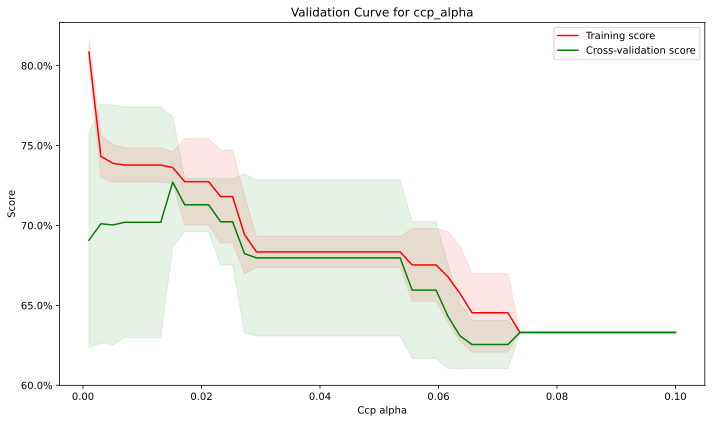

In [326]:
class DTClassifier(BaseClassifier):
    """TODO: Add default params for DT"""

    def __init__(
        self,
        config: Type[Config],
        param_grid: Dict[str, List[int]],
        eval_metric: str,
    ):
        super().__init__(
            model=DecisionTreeClassifier(random_state=config.RANDOM_SEED),
            config=config,
            param_grid=param_grid,
            eval_metric=eval_metric,
        )

    def fit(self, X: np.ndarray, y: np.array):
        """Fits the underlying estimator/model to the data

        Args:
            X np.array: Represents the independentfeatures used to train the model
            y np.array: Represents the target/response variable
            verbose (bool, optional): Flag to log additional information to the console

        Returns:
            DTClassifier: Returns the fitted model
        """
        if self.verbose:
            print("Fitting the model...")
        self.model.fit(X, y)
        if self.verbose:
            print("Model fitting completed.")
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Returns the mean response given a set of independent features

        Args:
            X (np.ndarray): Represents the independent features

        Returns:
            np.ndarray: Returns the mean response given the predictors
        """
        return self.model.predict(X)

    def plot_training_run_time(self, X, y, cv=5, show_plot=False):
        start_time = time.time()
        scores = cross_val_score(self.model, X, y, cv=cv)
        end_time = time.time()

        runtime = end_time - start_time

        plt.figure()
        plt.title(f"Training Runtime ({self.name})")
        plt.xlabel("Training examples")
        plt.ylabel("Runtime (seconds)")
        plt.bar(["Run Time"], [runtime])

        if show_plot:
            plt.show()

    def prune_tree(self):
        pass

    def export_tree(self):
        pass



# parameter_grid = {"max_depth": np.linspace(1, 11, 1)}
parameter_grid = {"ccp_alpha": np.linspace(0.1, 1.1, 1)}
eval_metric = "accuracy"
wine_dt = DTClassifier(config, parameter_grid, eval_metric)

scoring_func = wine_dt.get_scorer("accuracy")

best_param_value = wine_dt.plot_validation_curve(
    X,
    y,
    dataset_name="winequality-white",
    param_name="ccp_alpha",
    param_range=np.linspace(0.001, 0.1, 50),
    # param_range=np.arange(1, 21),
    save_plot=False,
    incr_threshold = 0.5
)

In [327]:
isinstance(best_param_value, float)

True

In [250]:
wine_dt.set_params(max_depth=best_param_value)
wine_dt.plot_learning_curve(
    X,
    y,
    param_name="max_depth",
    dataset_name="winequality-white",
    save_plot=False,
)

New Parameters Set: {'max_depth': 0}


ValueError: 
All the 25 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zacburns/Library/Caches/pypoetry/virtualenvs/cs7641-machine-learning-D-VmE0dw-py3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zacburns/Library/Caches/pypoetry/virtualenvs/cs7641-machine-learning-D-VmE0dw-py3.12/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/zacburns/Library/Caches/pypoetry/virtualenvs/cs7641-machine-learning-D-VmE0dw-py3.12/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/Users/zacburns/Library/Caches/pypoetry/virtualenvs/cs7641-machine-learning-D-VmE0dw-py3.12/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_depth' parameter of DecisionTreeClassifier must be an int in the range [1, inf) or None. Got 0 instead.


In [244]:
cross_val_score(DecisionTreeClassifier(max_depth=3), X, y, cv=5)

array([0.68538462, 0.71307692, 0.72594303, 0.80446497, 0.63895304])

Folder is already there
/Users/zacburns/Documents/Github/ML-Experiment-Runner/ml_experiment_runner/src/images/winequality_white_DTClassifier_validation_curve.png
New Parameters Set: {'max_depth': 3}
Folder is already there
/Users/zacburns/Documents/Github/ML-Experiment-Runner/ml_experiment_runner/src/images/winequality_white_DTClassifier_learning_curve.png


{'DTClassifier': {'DTClassifier_max_depth': 2}}

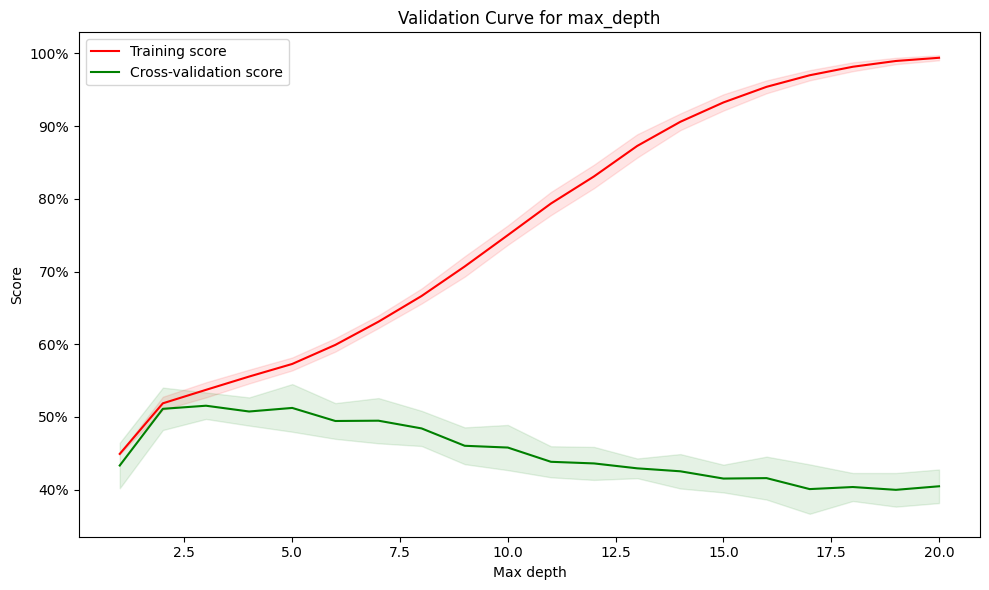

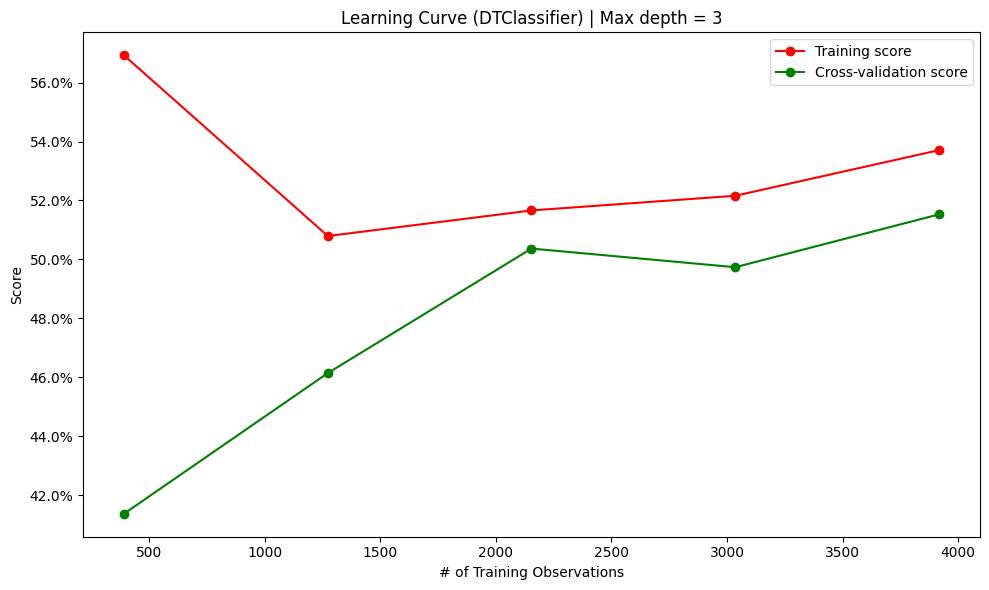

In [228]:
class MLExperimentRunner():
    def __init__(
        self,
        model_class: Type[Union[BaseClassifier, BaseEstimator]],
        data: Dataset,
        config: Type[Config],
        eval_metric: str,
        param_grid: Dict[str, float],
    ):
        self.model_class = model_class
        self.model = None
        self.data = data
        self.config = config
        self.param_grid = param_grid
        self.eval_metric = eval_metric
        self.seed = config.RANDOM_SEED
        self.verbose = config.VERBOSE

    def init_estimator(self) -> Union[BaseClassifier, BaseEstimator]:
        return self.model_class(self.config, self.eval_metric, self.param_grid)

    @property
    def base_experiment_name(self) -> str:
        # Check if underlying model has been instantiated
        if not self.model:
            self.model = self.init_estimator()
        
        return f"{self.model.name}_{self.data.name}"

    def save_training_results(self, learner: BaseEstimator) -> None:
        pass

    def save_test_results(self, learner: BaseEstimator) -> None:
        pass

    def log(self, msg, *args):
        """
        If the experiment is set to Verbose = True, log the message and the passed in arguments
        """
        if self._verbose:
            logger.info(msg.format(*args))

    def run_experiment(self, X: np.array, y: np.array, param_name: str, param_range: float, verbose = False) -> None:
        experiment_times = {}
        
        if verbose:
            logger.info(f"Running Experiment: {self.model.name} | Parameter Name: {param_name} = {list(param_range)}")
        
        start = datetime.now()
        
        estimator = self.model_class(self.config, self.param_grid, self.eval_metric)
        if verbose:
            logger.info(estimator.get_params())
            
        scoring_func = estimator.get_scorer(self.eval_metric)
        
        best_param_value = estimator.plot_validation_curve(
            X,
            y,
            dataset_name=self.data.name,
            param_name=param_name,
            param_range=param_range,
            save_plot=True,
        )
    
        estimator.set_params(max_depth=best_param_value)
        estimator.plot_learning_curve(
            X, y, param_name=param_name, dataset_name=self.data.name, save_plot=True
        )
        end = datetime.now()
        run_time = end - start

        experiment_times[f"{estimator.name}_{param_name}"] = run_time.seconds
        return experiment_times
    
    def main(self) -> Dict[str, float]:
        self.model = self.init_estimator()
        
        logger.info(f"Starting Experiments for: {self.model.name} | Dataset Name: {self.data.name}")
        experiment_details = {}
        for param_name, param_range in self.param_grid.items():
            experiment_details[self.model.name] = self.run_experiment(X, y, param_name, param_range, self.verbose)

        return experiment_details
        


#############################################################################
eval_metric = 'accuracy'

# Outlines what experiments we want to run. These get passed to the underlying estimator
param_grid = {
    'max_depth': np.arange(1, 21),
    # 'ccp_alpha': np.arange(0.1, 1, 0.1),
    # 'min_samples_per_leaf': np.arange(1, 101, 10),
}
# print(param_grid)
dt_experiment = MLExperimentRunner(DTClassifier, wine_data, config, eval_metric, param_grid)
# dt_experiment.experiment_name

# dt_experiment.run_experiment(X.values, y.values, 'max_depth', np.arange(1, 21), verbose = True)
exp_details = dt_experiment.main()
exp_details

Summarize dataset:  58%|████████████████████████▍                 | 95/163 [00:13<00:10,  6.80it/s, scatter pH, total sulfur dioxide]


KeyboardInterrupt: 

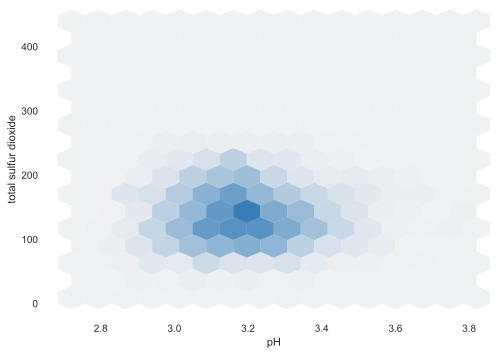

In [93]:
profile = ProfileReport(
    wine_df, title="winequality_white: Profiling Report"
)
report_path = get_directory(
    'images',
    "winequality_white",
    "analysis",
)
profile.to_file(report_path / "winequality_white_profile_report.html")

In [90]:
str(report_path)

'/Users/zacburns/Documents/Github/ML-Experiment-Runner/ml_experiment_runner/src/images/qinequality_white/analysis'

In [49]:
def build_pipeline(model, numeric_features, categorical_features, scale_features=False, normalize_features=False, scale_target=False, normalize_target=False):
    # Check scaling and normalization flags
    if scale_features and normalize_features:
        raise ValueError("Both scale_features and normalize_features cannot be True at the same time.")
    if scale_target and normalize_target:
        raise ValueError("Both scale_target and normalize_target cannot be True at the same time.")
    
    # Preprocessing for numeric features
    numeric_transformer = []
    if scale_features:
        numeric_transformer.append(('scaler', StandardScaler()))
    elif normalize_features:
        numeric_transformer.append(('scaler', MinMaxScaler()))
        
    numeric_transformer = Pipeline(steps=numeric_transformer)
    
    # Preprocessing for categorical features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Create pipeline
    steps = [('preprocessor', preprocessor), ('model', model)]
    pipeline = Pipeline(steps=steps)
    
    # Optionally scale the target
    if scale_target or normalize_target:
        target_scaler = TargetScaler(method='standard' if scale_target else 'minmax')
        pipeline = Pipeline(steps=[('target_scaler', target_scaler), ('pipeline', pipeline)])
    
    return pipeline